# Assignment 01: Multi-class Classification 
In this Assignment, you will train a deep model on the CIFAR10 from the scratch using PyTorch.

### Basic Imports

In [1]:
import os
import time
import os.path as osp

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
import torchvision

import matplotlib.pyplot as plt
from PIL import Image

### Hyperparameters

In [2]:
# random seed
SEED = 1 
NUM_CLASS = 10

# Training
BATCH_SIZE = 128
NUM_EPOCHS = 30
EVAL_INTERVAL=1
SAVE_DIR = './log'

# Optimizer
LEARNING_RATE = 1e-1
MOMENTUM = 0.9
STEP=5
GAMMA=0.5


### Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Dataset


In [4]:
# cifar10 transform
transform_cifar10_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_cifar10_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform_cifar10_train)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform_cifar10_test)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Files already downloaded and verified
Files already downloaded and verified


### Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 4, 3)  
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 8, 3)  
        self.fc1 = nn.Linear(8 * 6 * 6, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 8 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model1 = ConvNet()
model2 = ConvNet()
model3 = ConvNet()
model1.to(device)
model2.to(device)
model3.to(device)

ConvNet(
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=288, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [7]:
### Optimizer

In [8]:
optimizer1 = optim.SGD(model1.parameters(), lr=1e-1, momentum=MOMENTUM)
optimizer2 = optim.SGD(model2.parameters(), lr=1e-2, momentum=MOMENTUM)
optimizer3 = optim.SGD(model3.parameters(), lr=1e-3, momentum=MOMENTUM)

scheduler1 = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=STEP, gamma=GAMMA)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=STEP, gamma=GAMMA)
scheduler3 = torch.optim.lr_scheduler.StepLR(optimizer3, step_size=STEP, gamma=GAMMA)
#在经过step_size个epoch以后会调整学习率

### Task 1: per batch training/testing
---

Please denfine two function named ``train_batch`` and ``test_batch``. These functions are essential for training and evaluating machine learning models using batched data from dataloaders.

**To do**: 
1. Define the loss function i.e [nn.CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).
2. Take the image as the input and generate the output using the pre-defined SimpleNet.
3. Calculate the loss between the output and the corresponding label using the loss function.

In [9]:
##################### Write your answer here ##################
# Define the loss function
criterion = nn.CrossEntropyLoss()
###############################################################

In [10]:
def train_batch(model, image, target):
    """
    Perform one training batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to train.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated by the defined loss function loss_fn().
    """
    
    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

In [11]:

def test_batch(model, image, target):
    """
    Perform one testing batch iteration.

    Args:
        model (torch.nn.Module): The machine learning model to evaluate.
        image (torch.Tensor): Batch of input data (images).
        target (torch.Tensor): Batch of target labels.

    Returns:
        torch.Tensor: Model output (predictions) for the batch.
        torch.Tensor: Loss value calculated for the batch.
    """

    ##################### Write your answer here ##################
    output = model(image)
    loss = criterion(output,target)
    ###############################################################

    return output, loss

### Model Training when initial learning rate is 1e-1

In [12]:
training_loss_1 = []
training_acc_1 = []
testing_loss_1 = []
testing_acc_1 = []

for epoch in range(NUM_EPOCHS):
    model1.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    train_start_time = time.time()
    for batch_idx, (image, target) in enumerate(train_dataloader):
        
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model1, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer1.step()
        optimizer1.zero_grad()
        
    train_end_time = time.time()  
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'training run time:{train_end_time - train_start_time:.4f}')

    training_loss_1.append(epoch_loss)
    training_acc_1.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler1.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        
        model1.eval()
    
        val_loss = 0.0
        val_corrects = 0
        test_start_time = time.time()
        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model1, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
        test_end_time = time.time()
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'testing run time:{test_end_time - test_start_time:.4f}')
        testing_loss_1.append(val_loss)
        testing_acc_1.append(val_acc.cpu().detach().numpy())
        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model1.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0150 Acc: 0.2853
training run time:6.9246
Begin test......
Test Loss: 0.0139 Acc: 0.3449
testing run time:0.8669
Epoch: 2/30 Train Loss: 0.0139 Acc: 0.3437
training run time:6.6091
Begin test......
Test Loss: 0.0133 Acc: 0.3760
testing run time:0.8560
Epoch: 3/30 Train Loss: 0.0137 Acc: 0.3560
training run time:6.5824
Begin test......
Test Loss: 0.0135 Acc: 0.3614
testing run time:0.9234
Epoch: 4/30 Train Loss: 0.0135 Acc: 0.3692
training run time:6.5632
Begin test......
Test Loss: 0.0135 Acc: 0.3791
testing run time:0.8438
Epoch: 5/30 Train Loss: 0.0134 Acc: 0.3711
training run time:6.6694
Begin test......
Test Loss: 0.0130 Acc: 0.3966
testing run time:0.8459
Epoch: 6/30 Train Loss: 0.0125 Acc: 0.4123
training run time:6.6547
Begin test......
Test Loss: 0.0118 Acc: 0.4458
testing run time:0.8974
Epoch: 7/30 Train Loss: 0.0123 Acc: 0.4240
training run time:6.5674
Begin test......
Test Loss: 0.0118 Acc: 0.4557
testing run time:0.8372
Epoch: 8/30 Train Loss: 0.0

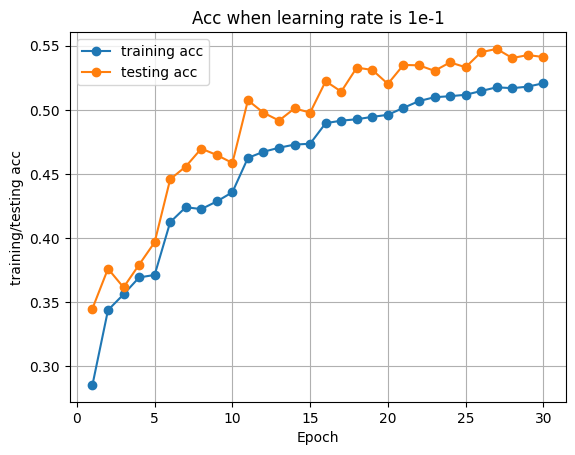

In [13]:
y1 = training_acc_1
y2 = testing_acc_1
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = 'training acc')
plt.plot(x, y2,linestyle='-', marker='o',label = 'testing acc')
plt.title('Acc when learning rate is 1e-1')
plt.xlabel('Epoch')
plt.ylabel('training/testing acc')
plt.legend()
plt.grid(True)
plt.savefig('figs/Acc1e-1.png')

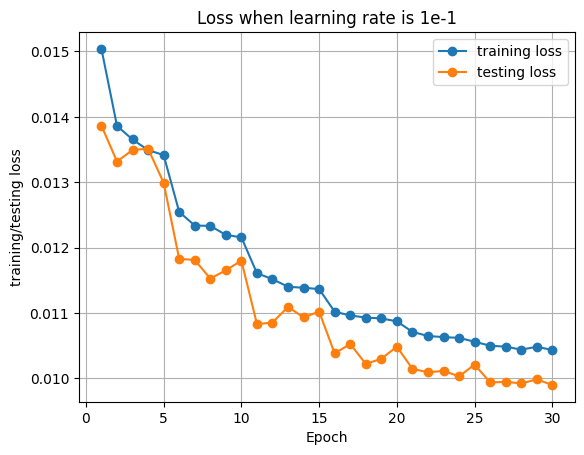

In [14]:
y1 = training_loss_1
y2 = testing_loss_1
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = 'training loss')
plt.plot(x, y2,linestyle='-', marker='o',label = 'testing loss')
plt.title('Loss when learning rate is 1e-1')
plt.xlabel('Epoch')
plt.ylabel('training/testing loss')
plt.legend()
plt.grid(True)
plt.savefig('figs/Loss1e-1.png')

### Model Training when initial learning rate is 1e-2

In [15]:
training_loss_2 = []
training_acc_2 = []
testing_loss_2 = []
testing_acc_2 = []

for epoch in range(NUM_EPOCHS):
    model2.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    train_start_time = time.time()
    for batch_idx, (image, target) in enumerate(train_dataloader):
        
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model2, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer2.step()
        optimizer2.zero_grad()
        
    train_end_time = time.time()  
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'training run time:{train_end_time - train_start_time:.4f}')

    training_loss_2.append(epoch_loss)
    training_acc_2.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler2.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        
        model2.eval()
    
        val_loss = 0.0
        val_corrects = 0
        test_start_time = time.time()
        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model2, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
        test_end_time = time.time()
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'testing run time:{test_end_time - test_start_time:.4f}')
        testing_loss_2.append(val_loss)
        testing_acc_2.append(val_acc.cpu().detach().numpy())
        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model2.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0152 Acc: 0.2906
training run time:6.5919
Begin test......
Test Loss: 0.0128 Acc: 0.4216
testing run time:0.8788
Epoch: 2/30 Train Loss: 0.0129 Acc: 0.4034
training run time:6.6608
Begin test......
Test Loss: 0.0117 Acc: 0.4635
testing run time:0.8674
Epoch: 3/30 Train Loss: 0.0122 Acc: 0.4348
training run time:6.5191
Begin test......
Test Loss: 0.0111 Acc: 0.4936
testing run time:0.8749
Epoch: 4/30 Train Loss: 0.0118 Acc: 0.4563
training run time:6.6570
Begin test......
Test Loss: 0.0106 Acc: 0.5121
testing run time:0.8637
Epoch: 5/30 Train Loss: 0.0114 Acc: 0.4750
training run time:6.6525
Begin test......
Test Loss: 0.0109 Acc: 0.5019
testing run time:0.8719
Epoch: 6/30 Train Loss: 0.0109 Acc: 0.4956
training run time:6.7044
Begin test......
Test Loss: 0.0102 Acc: 0.5345
testing run time:0.8320
Epoch: 7/30 Train Loss: 0.0108 Acc: 0.5035
training run time:6.9611
Begin test......
Test Loss: 0.0100 Acc: 0.5386
testing run time:0.9269
Epoch: 8/30 Train Loss: 0.0

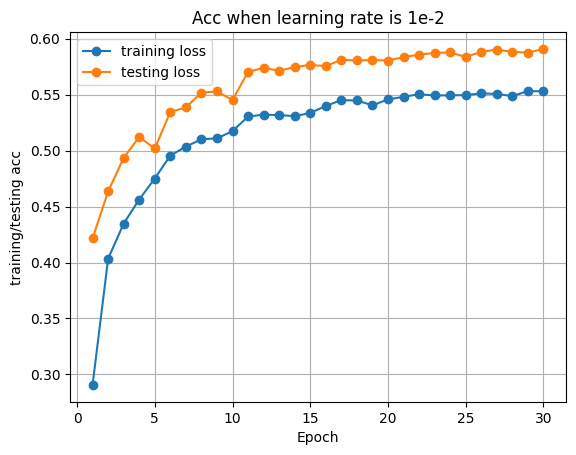

In [16]:
y1 = training_acc_2
y2 = testing_acc_2
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = 'training loss')
plt.plot(x, y2,linestyle='-', marker='o',label = 'testing loss')
plt.title('Acc when learning rate is 1e-2')
plt.xlabel('Epoch')
plt.ylabel('training/testing acc')
plt.legend()
plt.grid(True)
plt.savefig('figs/Acc1e-2.png')

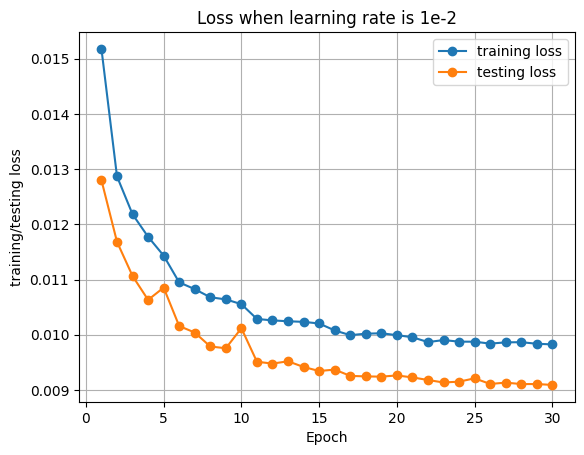

In [17]:
y1 = training_loss_2
y2 = testing_loss_2
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = 'training loss')
plt.plot(x, y2,linestyle='-', marker='o',label = 'testing loss')
plt.title('Loss when learning rate is 1e-2')
plt.xlabel('Epoch')
plt.ylabel('training/testing loss')
plt.legend()
plt.grid(True)
plt.savefig('figs/Loss1e-2.png')

### Model Training when initial learning rate is 1e-3

In [18]:
training_loss_3 = []
training_acc_3 = []
testing_loss_3 = []
testing_acc_3 = []

for epoch in range(NUM_EPOCHS):
    model3.train()
    torch.cuda.empty_cache()

    ##########################
    ### Training
    ##########################

    running_cls_loss = 0.0
    running_cls_corrects = 0
    train_start_time = time.time()
    for batch_idx, (image, target) in enumerate(train_dataloader):
        
        image = image.to(device)
        target = target.to(device)

        # train model
        outputs, loss = train_batch(model3, image, target)
        _, preds = torch.max(outputs, 1)

        
        loss_data = loss.data.item()
        if np.isnan(loss_data):
            raise ValueError('loss is nan while training')
        running_cls_loss += loss.item()
        running_cls_corrects += torch.sum(preds == target.data)

        loss.backward()
        optimizer3.step()
        optimizer3.zero_grad()
        
    train_end_time = time.time()  
    epoch_loss = running_cls_loss / len(train_set)
    epoch_acc = running_cls_corrects.double() / len(train_set)
    
    print(f'Epoch: {epoch+1}/{NUM_EPOCHS} Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    print(f'training run time:{train_end_time - train_start_time:.4f}')

    training_loss_3.append(epoch_loss)
    training_acc_3.append(epoch_acc.cpu().detach().numpy())

    # change learning rate
    scheduler3.step()


    ##########################
    ### Testing
    ##########################
    # # eval model during training or in the last epoch
    if (epoch + 1) % EVAL_INTERVAL == 0 or (epoch +1) == NUM_EPOCHS:
        print('Begin test......')
        
        model3.eval()
    
        val_loss = 0.0
        val_corrects = 0
        test_start_time = time.time()
        for batch_idx, (image, target) in enumerate(test_dataloader):

            image = image.to(device)
            target = target.to(device)

            # test model
            outputs, loss = test_batch(model3, image, target)
            _, preds = torch.max(outputs, 1)
            
            val_loss += loss.item()
            val_corrects += torch.sum(preds == target.data)
            
        test_end_time = time.time()
        val_loss = val_loss / len(test_set)
        val_acc = val_corrects.double() / len(test_set)
        print(f'Test Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        print(f'testing run time:{test_end_time - test_start_time:.4f}')
        testing_loss_3.append(val_loss)
        testing_acc_3.append(val_acc.cpu().detach().numpy())
        # save the model in last epoch
        if (epoch +1) == NUM_EPOCHS:
            
            state = {
            'state_dict': model3.state_dict(),
            'acc': epoch_acc,
            'epoch': (epoch+1),
            }

            # check the dir
            if not os.path.exists(SAVE_DIR):
                os.makedirs(SAVE_DIR)

            # save the state
            torch.save(state, osp.join(SAVE_DIR, 'checkpoint_%s.pth' % (str(epoch+1))))

Epoch: 1/30 Train Loss: 0.0177 Acc: 0.1330
training run time:6.6083
Begin test......
Test Loss: 0.0173 Acc: 0.1739
testing run time:0.8485
Epoch: 2/30 Train Loss: 0.0164 Acc: 0.2333
training run time:6.6136
Begin test......
Test Loss: 0.0158 Acc: 0.2724
testing run time:0.8455
Epoch: 3/30 Train Loss: 0.0156 Acc: 0.2767
training run time:6.6318
Begin test......
Test Loss: 0.0151 Acc: 0.3145
testing run time:0.8503
Epoch: 4/30 Train Loss: 0.0150 Acc: 0.3084
training run time:6.5426
Begin test......
Test Loss: 0.0144 Acc: 0.3417
testing run time:0.8707
Epoch: 5/30 Train Loss: 0.0144 Acc: 0.3296
training run time:6.6818
Begin test......
Test Loss: 0.0137 Acc: 0.3753
testing run time:0.8470
Epoch: 6/30 Train Loss: 0.0140 Acc: 0.3487
training run time:6.5904
Begin test......
Test Loss: 0.0134 Acc: 0.3849
testing run time:0.8614
Epoch: 7/30 Train Loss: 0.0138 Acc: 0.3558
training run time:6.5830
Begin test......
Test Loss: 0.0132 Acc: 0.3924
testing run time:0.8669
Epoch: 8/30 Train Loss: 0.0

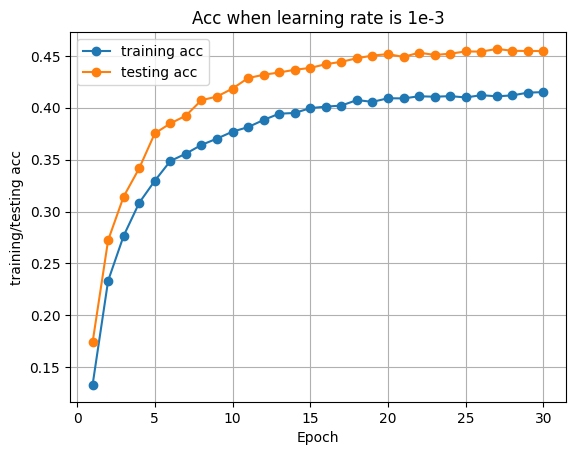

In [19]:
y1 = training_acc_3
y2 = testing_acc_3
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = 'training acc')
plt.plot(x, y2,linestyle='-', marker='o',label = 'testing acc')
plt.title('Acc when learning rate is 1e-3')
plt.xlabel('Epoch')
plt.ylabel('training/testing acc')
plt.legend()
plt.grid(True)
plt.savefig('figs/Acc1e-3.png')

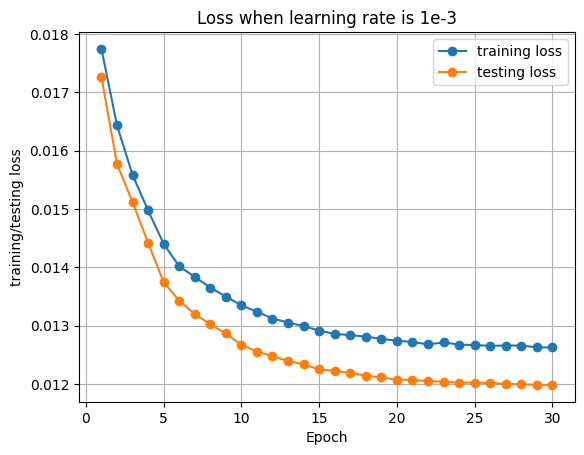

In [20]:
y1 = training_loss_3
y2 = testing_loss_3
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = 'training loss')
plt.plot(x, y2,linestyle='-', marker='o',label = 'testing loss')
plt.title('Loss when learning rate is 1e-3')
plt.xlabel('Epoch')
plt.ylabel('training/testing loss')
plt.legend()
plt.grid(True)
plt.savefig('figs/Loss1e-3.png')

### Comparison for all three

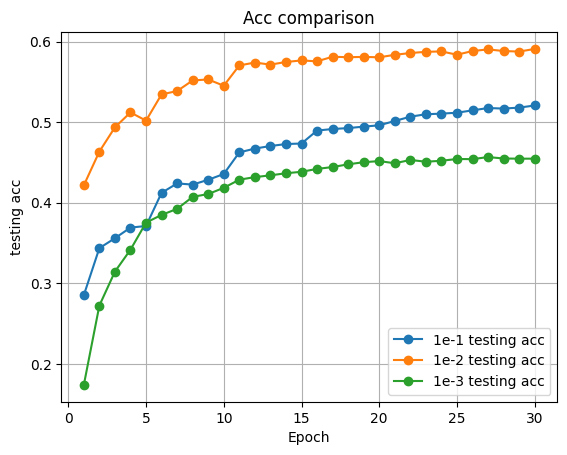

In [21]:
y1 = training_acc_1
y2 = testing_acc_2
y3 = testing_acc_3
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = '1e-1 testing acc')
plt.plot(x, y2,linestyle='-', marker='o',label = '1e-2 testing acc')
plt.plot(x, y3,linestyle='-', marker='o',label = '1e-3 testing acc')
plt.title('Acc comparison')
plt.xlabel('Epoch')
plt.ylabel('testing acc')
plt.legend()
plt.grid(True)
plt.savefig('figs/AccC.png')

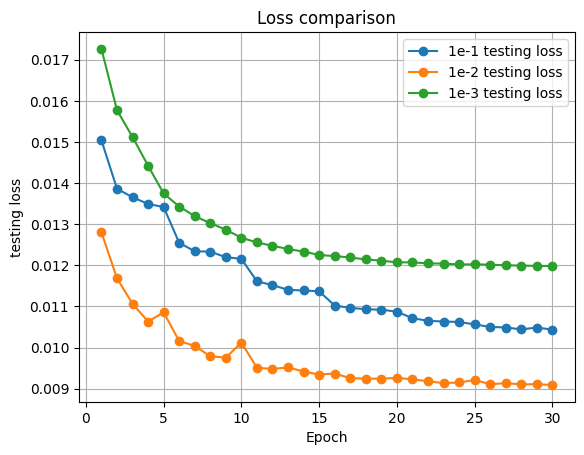

In [22]:
y1 = training_loss_1
y2 = testing_loss_2
y3 = testing_loss_3
x = np.arange(1,NUM_EPOCHS + 1)
plt.plot(x, y1,linestyle='-', marker='o',label = '1e-1 testing loss')
plt.plot(x, y2,linestyle='-', marker='o',label = '1e-2 testing loss')
plt.plot(x, y3,linestyle='-', marker='o',label = '1e-3 testing loss')
plt.title('Loss comparison')
plt.xlabel('Epoch')
plt.ylabel('testing loss')
plt.legend()
plt.grid(True)
plt.savefig('figs/LossC.png')

### Task 2: Instance inference
---
The task is to visualizes an image along with model prediction and class probabilities.

**To do**: 
1. Calculate the prediction and the probabilities for each class.
         

In [23]:
inputs, classes = next(iter(test_dataloader))
input = inputs[0]

In [24]:
##################### Write your answer here ##################
# input: image, model
# outputs: predict_label, probabilities
# predict_label is the index (or label) of the class with the highest probability from the probabilities.
###############################################################
probabilities = F.softmax(model1(input.to(device)), dim=1)
#probabilities = softmax.numpy()
#probabilities = torch.softmax(model(input.to(device)),dim = 1)
predict_label = torch.argmax(probabilities,dim = 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


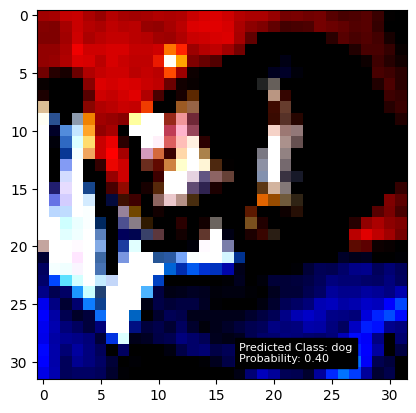

Print probabilities for each class:
airplane: 0.0135
automobile: 0.0055
bird: 0.0550
cat: 0.3153
deer: 0.0208
dog: 0.3955
frog: 0.0634
horse: 0.0613
ship: 0.0645
truck: 0.0052


In [25]:
predicted_class = class_names[predict_label.item()]
predicted_probability = probabilities[0,predict_label].item()
image = input.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.text(17, 30, f'Predicted Class: {predicted_class}\nProbability: {predicted_probability:.2f}', 
            color='white', backgroundcolor='black', fontsize=8)
plt.show()

# Print probabilities for each class
print('Print probabilities for each class:')
for i in range(len(class_names)):
    print(f'{class_names[i]}: {probabilities[0,i].item():.4f}')